In [16]:
import os

os.environ["OMP_NUM_THREADS"] = "2"

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import corner
import batman
import emcee
import time
from multiprocessing import Pool
from scipy import optimize
from IPython.display import display, Math

In [18]:
np.random.seed(100)


In [19]:
#System
#http://exoplanets.org/detail/Kepler-19_b
#Semi-Major Axis[au]	0.0846 ± 0.00141
#Orbital Period[day]	9.2869944 ± 8.8×10-6
#Orbit Inclination[deg]	89.94 +0.15/-0.35
#Planetary Radius[rjupiter]	0.1971 ± 0.0043
#Radius of Star[rsun]	0.850 ± 0.018

#Star
#Teff[k]	5541 ± 60
#[Fe/H]	-0.130 ± 0.06
#log10(g)	4.59 ± 0.1
#Using - https://astroutils.astronomy.osu.edu/exofast/limbdark.shtml
#Kepler bandpass
#Quadratic coefficients:
#   0.43135341      0.24553668


#TESS has a cadence of 2 minutes
#0.2 of a day has 144 measurements

In [20]:
def radius_in_stellar_radii(R_planet, R_star):
    """
    Convert planetary radius (R_Jupiter) in stellar radii.
    
    Parameters
    ----------
    R_planet : float
        Planetary radius in R_Jupiter.

    R_star : float
        Stellar radius in R_sun.

    Returns
    -------
    R_planet_stellar_radii : float 
        Planetary radius in stellar radii.

    """
    # 1 R_Jupiter = 0.102763 R_sun

    R_planet_stellar_radii = R_planet * 0.102763 / R_star

    return R_planet_stellar_radii

In [21]:
def semi_major_axis_in_stellar_radii(semi_major_axis, R_star):
    """
    Converting the semi-major axis (AU) to (Stellar radii)

    Parameters
    ----------
    semi_major_axis : float
        Semi-major axis of the planet in AU.

    R_star : float
        Stellar radius in R_sun.

    Returns
    -------
    a_stellar_radii : float
        Semi-major axis of the planet in stellar radii
    """
    #1 AU = 215.032 R_Sun

    a_stellar_radii = semi_major_axis * 215.032 / R_star #Check this

    return a_stellar_radii

In [22]:
true_R_star = 0.850 #R_sun
true_R_planet = 0.1971 #R_J
true_semi_major_axis = 0.0846 #AU 


params = batman.TransitParams()
params.t0 = 0.                                          #time of inferior conjunction
params.per = 9.2869944                                        #orbital period (days)
params.rp = radius_in_stellar_radii(true_R_planet, true_R_star)                #planet radius (in units of stellar radii)
params.a = semi_major_axis_in_stellar_radii(true_semi_major_axis, true_R_star) #semi-major axis (in units of stellar radii))
params.inc = 89.94                                      #orbital inclination (in degrees)
params.ecc = 0.0                                         #eccentricity
params.w = 90.                                          #longitude of periastron (in degrees)
params.limb_dark = "quadratic"                          #limb darkening model
params.u = [0.43135341, 0.24553668]                             #limb darkening coefficients [u1, u2, u3, u4]

t = np.linspace(-0.2, 0.2, 288)                      #times at which to calculate light curve
m = batman.TransitModel(params, t)                      #initializes model
true_flux = m.light_curve(params)

In [23]:
#Add noise to the signal
sigma = 0.00001
yerrs = np.random.normal(loc=0., scale=sigma, size=len(true_flux))
true_flux += yerrs
ysigmas = np.full(len(true_flux), sigma)

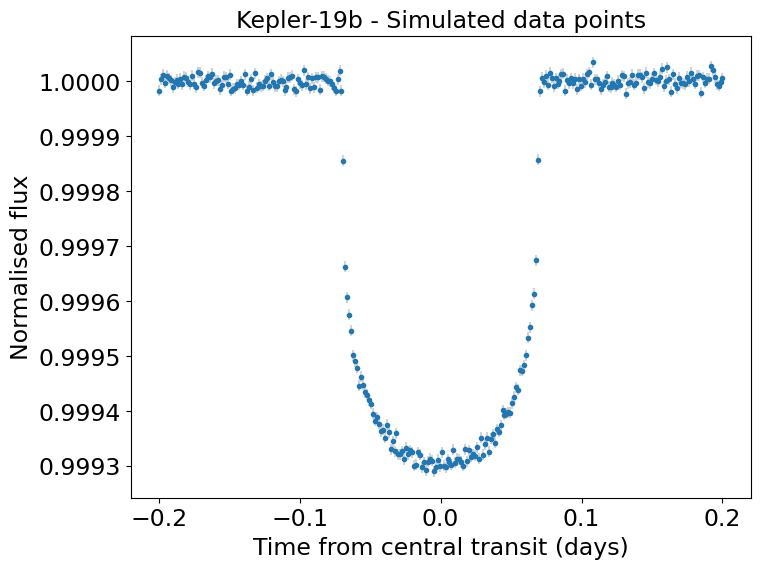

In [24]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.title("Kepler-19b - Simulated data points", size=17)
plt.errorbar(t, true_flux, yerr=ysigmas, fmt='.', ecolor='LightGrey', label="Expected")
plt.xlabel("Time from central transit (days)", size=17)
plt.ylabel("Normalised flux", size=17)

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)
plt.show()

In [25]:

guess_params = batman.TransitParams()
guess_params.t0 = params.t0
guess_params.per = params.per


guess_params.ecc = params.ecc
guess_params.w = params.w
guess_params.limb_dark = "quadratic"
guess_params.u = params.u

In [26]:
def log_likelihood(prior_params, true_flux, yerrs):
    """
    
    Parameters
    ----------


    Returns
    -------
    
    """
    orbital_inclination, R_planet, semi_major_axis = prior_params

    guess_params.rp = radius_in_stellar_radii(R_planet, true_R_star)
    guess_params.inc = orbital_inclination
    guess_params.a = semi_major_axis_in_stellar_radii(semi_major_axis, true_R_star)

    
    guess_m = batman.TransitModel(guess_params, t)
    guess_flux = guess_m.light_curve(guess_params)
        
    L1 = -0.5 * np.power((true_flux - guess_flux), 2) / np.power(yerrs, 2) #Sigma
    L2 = -0.5 * np.log(2 * np.pi * yerrs**2) #Sigma
    L3 = np.sum(L1) + np.sum(L2)
    return L3


def log_prior(prior_params):
    """
    
    Parameters
    ----------


    Returns
    -------
    
    """
    orbital_inclination, R_planet, semi_major_axis = prior_params

    P = 0.0
    if (orbital_inclination > 90) or (orbital_inclination < 87):
        P += -np.inf
        return -np.inf
    
    if (R_planet < 0) or (R_planet > 0.5):
        P += -np.inf
        return P

    if (semi_major_axis < 0) or (semi_major_axis > 0.3):
        P += -np.inf
        return P

    return P

def log_prob(prior_params, true_flux, yerrs):
    lp = log_prior(prior_params)
    # if not np.isfinite(lp):
    #     return -np.inf

    return log_likelihood(prior_params, true_flux, yerrs) + lp

In [27]:
#orbital_inclination, R_planet, semi_major_axis
#guess = [89, 0.18, 0.08]
guess = [params.inc, true_R_planet, true_semi_major_axis]
# bnds = ((45, 90), (0, 0.3), (0, 0.2)) #Boundaries

# nll = lambda *args: -log_likelihood(*args)

# likelihood_model = optimize.minimize(nll, guess, args=(true_flux, ysigmas), bounds=bnds)
# model_orbital_inclination, model_R_planet, model_semi_major_axis = likelihood_model['x']
# print(likelihood_model)



In [28]:
pos = guess + 1E-4 * np.random.randn(32, 3)

nwalkers, ndim = pos.shape

with Pool() as pool:
    start_time = time.time()
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(true_flux, ysigmas), a=2)
    sampler.run_mcmc(pos, 50000, progress=True)
    end_time = time.time() 
    execution_time = (end_time - start_time)
    print("Start:       {}".format(time.ctime(int(start_time))))
    print("End:         {}".format(time.ctime(int(end_time))))
    print("Time taken:  {:.2f} s".format(execution_time))



100%|██████████| 50000/50000 [08:31<00:00, 97.79it/s] 

Start:       Thu Dec 15 23:49:25 2022
End:         Thu Dec 15 23:57:57 2022
Time taken:  511.34 s


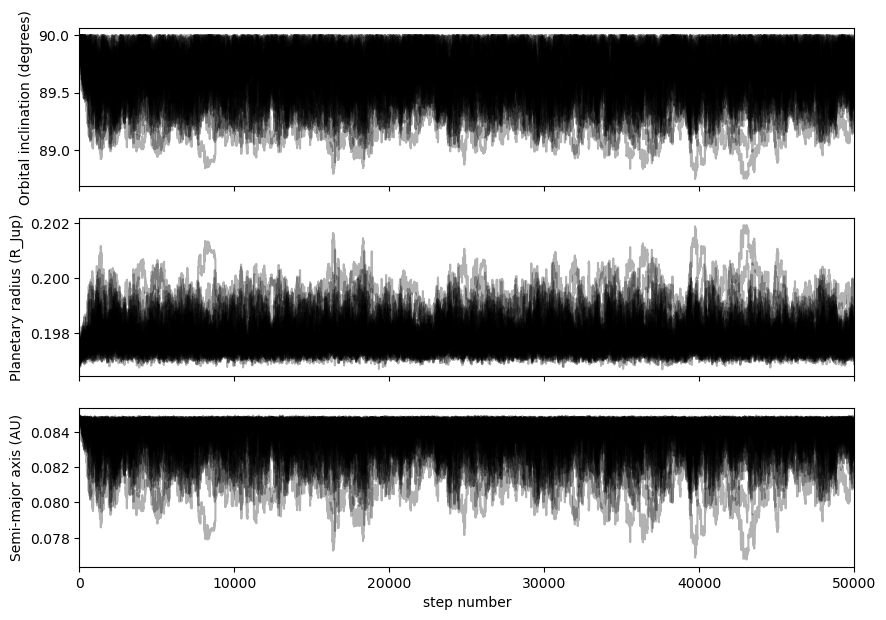

In [29]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Orbital inclination (degrees)", "Planetary radius (R_Jup)", "Semi-major axis (AU)"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

In [30]:
tau = sampler.get_autocorr_time()
print(tau)

[596.47580894 617.45857063 643.38725307]


In [31]:
flat_samples = sampler.get_chain(discard=400, thin=15, flat=True)
print(flat_samples.shape)

(105792, 3)


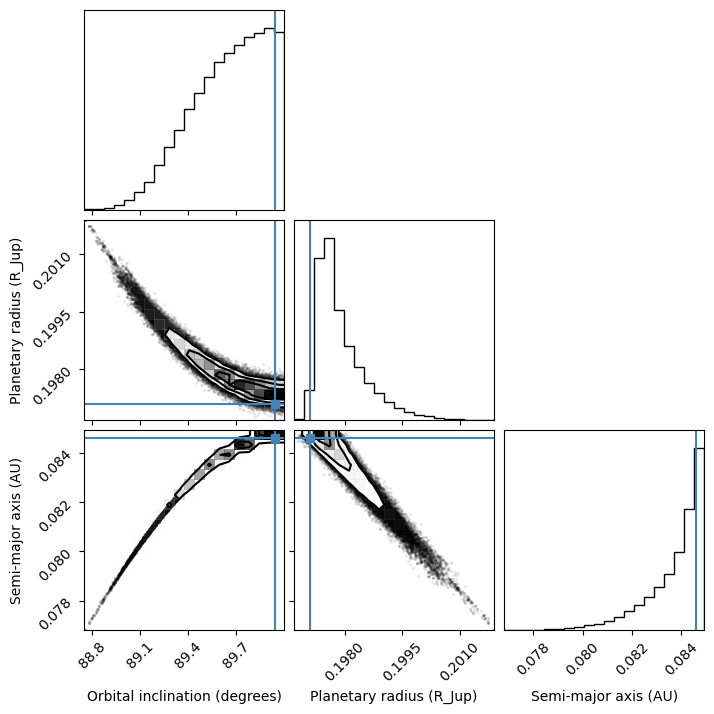

In [32]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[params.inc, true_R_planet, true_semi_major_axis])

In [33]:
inds = np.random.randint(len(flat_samples), size=100)

In [34]:
model_params = batman.TransitParams()
model_params.t0 = params.t0
model_params.per = params.per

model_params.ecc = params.ecc
model_params.w = params.ecc
model_params.limb_dark = "quadratic"
model_params.u = params.u

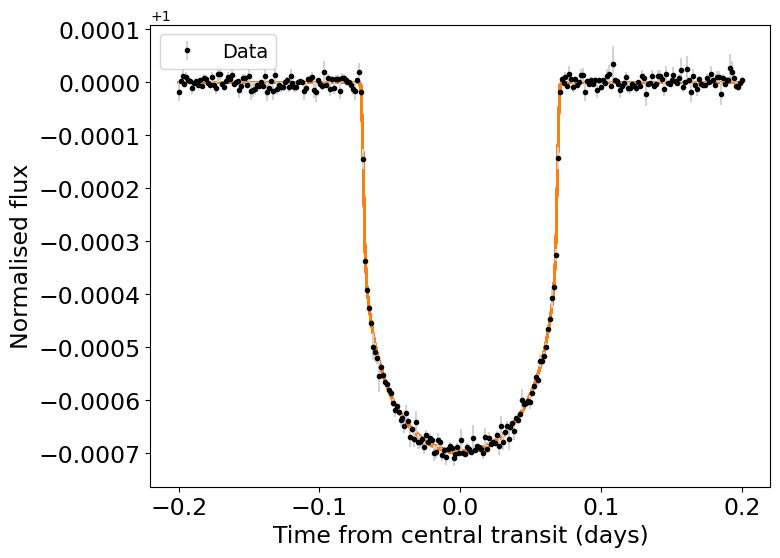

In [35]:
fig, ax = plt.subplots(1, figsize=(8,6))

inds = np.random.randint(len(flat_samples), size=1000)
for ind in inds:
    
    model_orbital_inclination, model_R_planet, model_semi_major_axis = flat_samples[ind]

    model_params.rp = radius_in_stellar_radii(model_R_planet, true_R_star)
    model_params.a = semi_major_axis_in_stellar_radii(model_semi_major_axis, true_R_star)
    model_params.inc = model_orbital_inclination

    model_m = batman.TransitModel(model_params, t)
    model_flux = model_m.light_curve(model_params)

    plt.plot(t, model_flux, "C1", alpha=0.1)

plt.errorbar(t, true_flux, yerr=yerrs, fmt=".", color="black", ecolor="LightGrey", label="Data")

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)

plt.legend(fontsize=14)
plt.xlabel("Time from central transit (days)", size=17)
plt.ylabel("Normalised flux", size=17)
plt.show()

In [36]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [37]:
residual = true_flux - model_flux

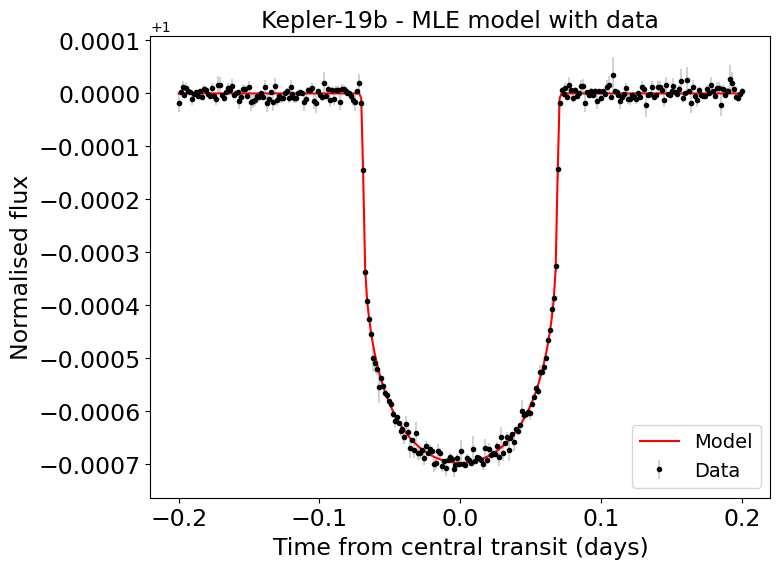

In [38]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.title("Kepler-19b - MLE model with data", size=17)
plt.errorbar(t, true_flux, yerr=yerrs, fmt='.', ecolor='LightGrey', color="black", label="Data")
plt.plot(t, model_flux, label="Model", color="red")
plt.xlabel("Time from central transit (days)", size=17)
plt.ylabel("Normalised flux", size=17)

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)
ax.legend(prop={'size': 14}, loc="lower right")

plt.show()

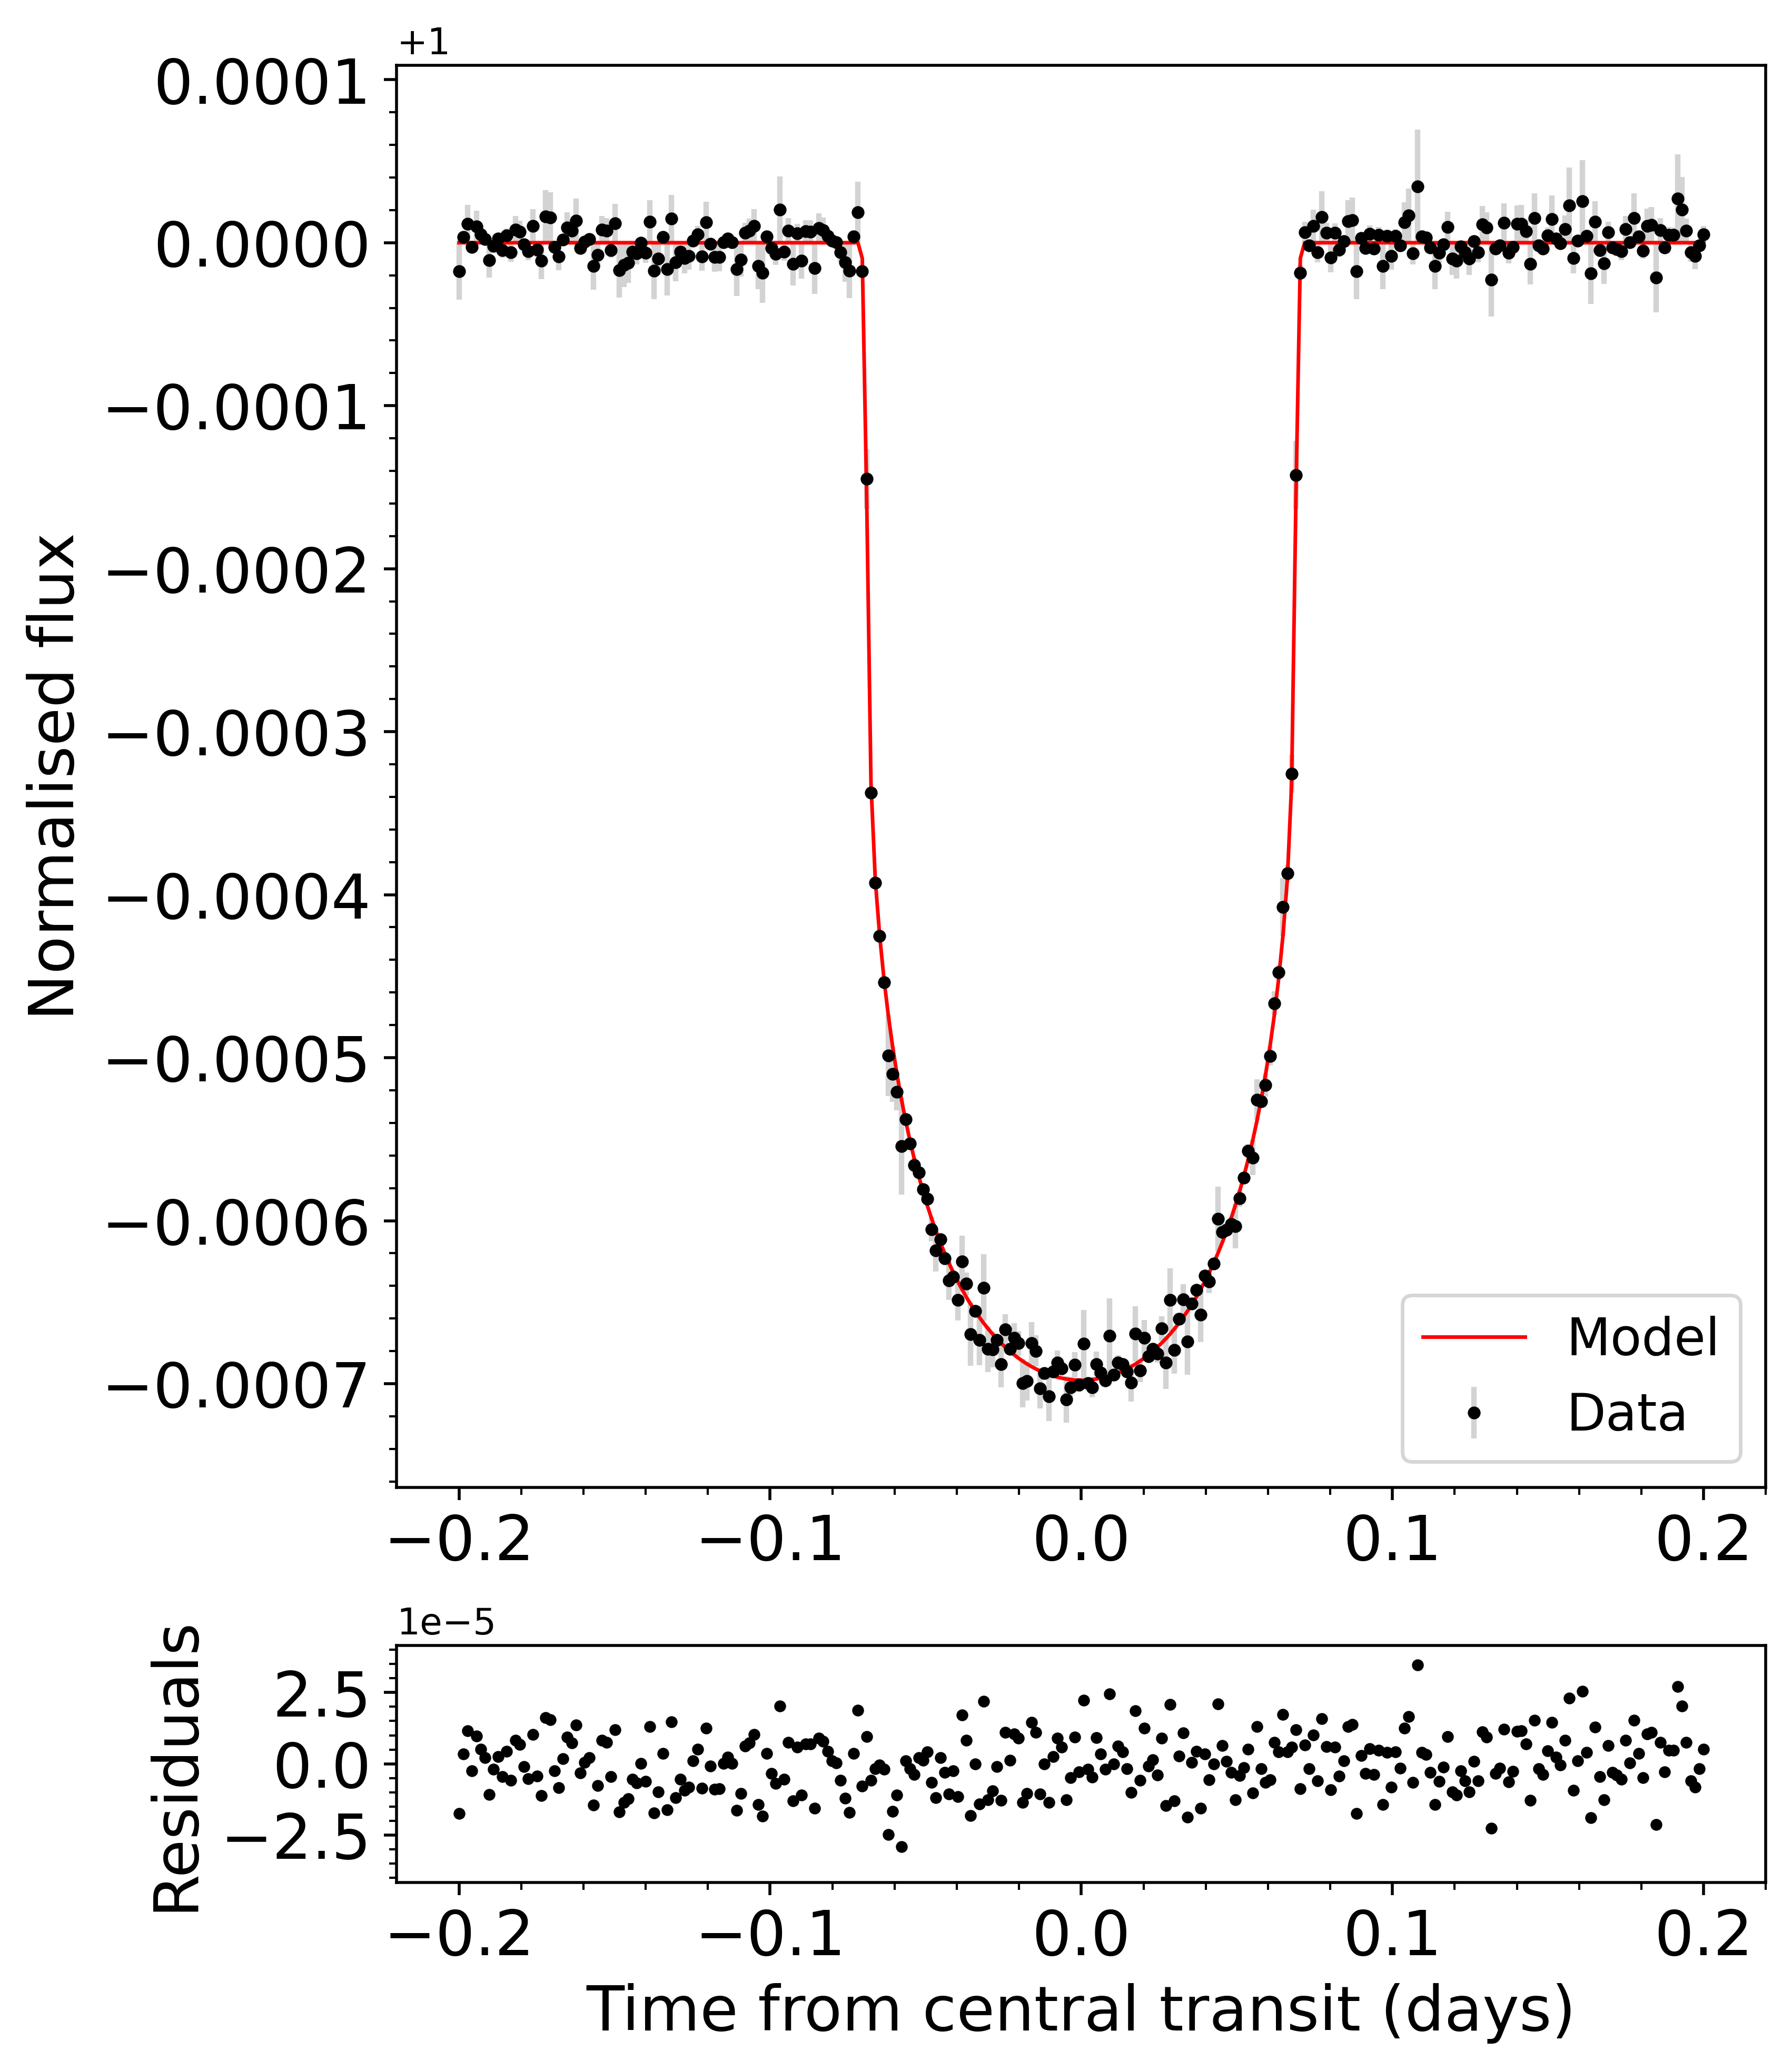

In [39]:
#Panel settings
left = 0.1
bottom = 0.1
width = 0.65
height = 0.9
spacing = -1.15

rect = [left, bottom, width, height]
rect_res = [left, bottom+height+spacing, width, 0.15]

fig = plt.figure(figsize=(8, 6), dpi=500)
ax = fig.add_axes(rect)

ax_res = fig.add_axes(rect_res, sharex=ax)

#Top panel
ax.errorbar(t, true_flux, yerr=yerrs, fmt='.', markersize=5, color='black', ecolor='LightGrey', label="Data")
ax.plot(t, model_flux, color='red',label="Model", lw=1)

ax.set(ylabel="Normalised flux")
ax.xaxis.label.set_size(17)
ax.yaxis.label.set_size(17)

ax.legend(prop={'size': 14}, loc="lower right")

ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)

#Bottom panel
ax_res.scatter(t, residual, color='black', s=5)
ax_res.set_ylim((-max(abs(residual))*1.2, max(abs(residual)*1.2)))
# ax_res.plot([min(t), max(t)], [0, 0], color='red', lw=1)

ax_res.set(xlabel="Time from central transit (days)", ylabel="Residuals")
ax_res.xaxis.label.set_size(17)
ax_res.yaxis.label.set_size(17)

ax_res.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax_res.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax_res.xaxis.set_tick_params(labelsize=17)
ax_res.yaxis.set_tick_params(labelsize=17)

# fig.subplots_adjust(hspace=0.1)
plt.show()